In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *

In [4]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/fatima_moqran/.fastai/data/planet')

In [5]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

train-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
train_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! conda install -y -c haasad eidl7zip

Solving environment: done

# All requested packages already installed.



In [7]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [8]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [11]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [12]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [26]:
      data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

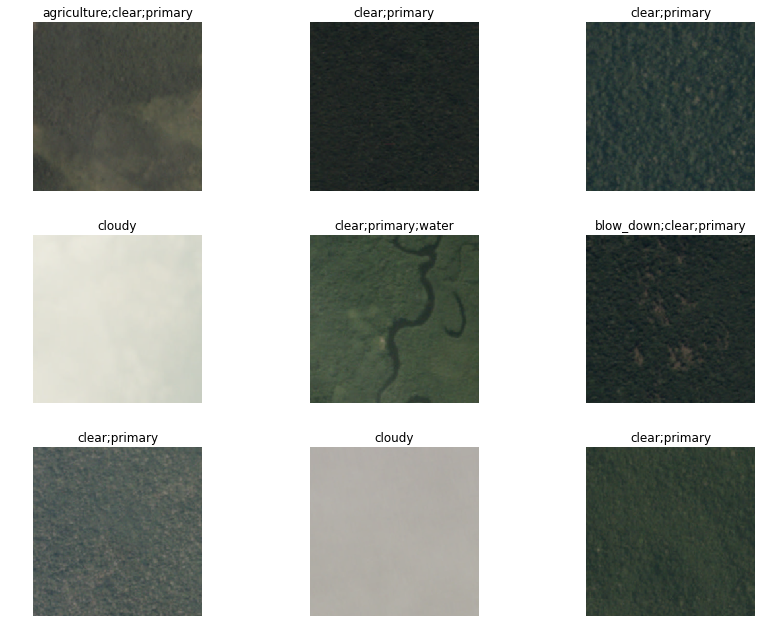

In [27]:
data.show_batch(rows=3, figsize=(12,9))

In [31]:
arch = models.resnet50

In [32]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


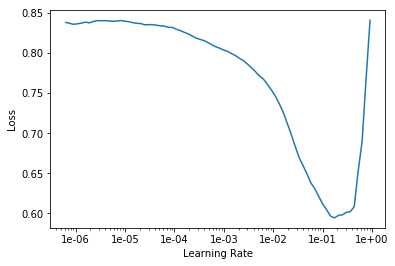

In [34]:
learn.recorder.plot()

In [35]:
lr = 0.01

In [36]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.119348,0.105418,0.948225,0.906593,02:46
1,0.108180,0.097728,0.952752,0.910897,02:45
2,0.100048,0.089341,0.958500,0.922509,02:45
3,0.092801,0.085428,0.956676,0.926335,02:45
4,0.086942,0.084283,0.956887,0.927638,02:45


In [37]:
learn.save('stage-2-size256-rn50')

In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


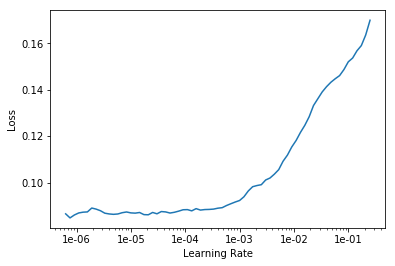

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.094612,0.087634,0.954983,0.925237,03:39
1,0.095750,0.088461,0.957120,0.923006,03:39
2,0.088723,0.083707,0.956865,0.927593,03:38
3,0.083979,0.081714,0.958863,0.929663,03:38
4,0.078727,0.081202,0.959561,0.929897,03:39


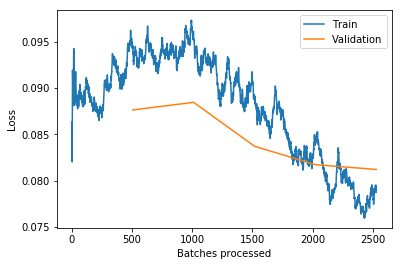

In [41]:
learn.recorder.plot_losses()

In [42]:
learn.save('stage-2-256-rn50')

In [46]:
learn.export()

In [43]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

100%|███████████████████████████████████████▊| 601M/603M [00:13<00:00, 24.3MB/s]
100%|████████████████████████████████████████| 603M/603M [00:13<00:00, 45.5MB/s]
 94%|█████████████████████████████████████▍  | 284M/304M [00:07<00:00, 61.2MB/s]
100%|████████████████████████████████████████| 304M/304M [00:07<00:00, 44.0MB/s]


In [44]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [47]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [48]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [49]:
labelled_preds[:5]

['clear primary',
 'clear primary',
 'clear primary road water',
 'haze primary',
 'clear primary']

In [50]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [51]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [52]:
df.to_csv(path/'submission.csv', index=False)

In [54]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|███████████████████████████████████████| 2.19M/2.19M [00:04<00:00, 525kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space